# Mecklin cumulative polyp risk
Last updated 10/21/2025

In [89]:
import sys
import os

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from csaps import csaps

PARENT_DIR = "/Users/sophiewagner/repos/lynch-syndrome"
DATA_DIR = os.path.join(PARENT_DIR, "data")

In [90]:
# Load data
file_path = os.path.join(DATA_DIR, "mecklin_polyp_cum_risk.xlsx")
df_m = pd.read_excel(file_path, sheet_name="male", index_col=False)
df_f = pd.read_excel(file_path, sheet_name="female", index_col=False)

## View extracted data

In [91]:
# Pivot long → wide: each 'item' becomes its own column
df_wide_m = (
    df_m.pivot_table(index="age", columns="item", values="risk")
      .reset_index()
      .sort_values("age")
)
df_wide_f = (
    df_f.pivot_table(index="age", columns="item", values="risk")
      .reset_index()
      .sort_values("age")
)

# Optional: interpolate missing values to align more smoothly
df_wide_m = df_wide_m.interpolate(method='linear')
df_wide_f = df_wide_f.interpolate(method='linear')

# Check result
# print(df_wide_m.head(20))
# print(df_wide_f.head(20))

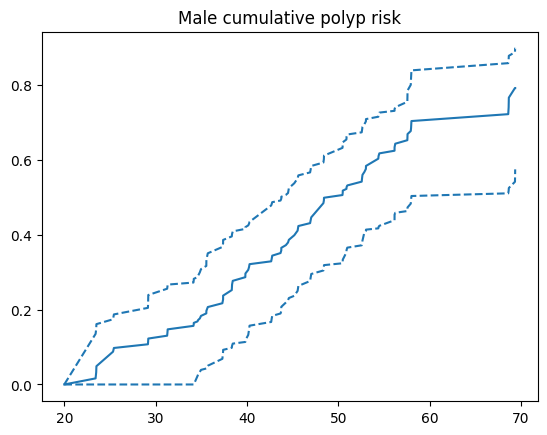

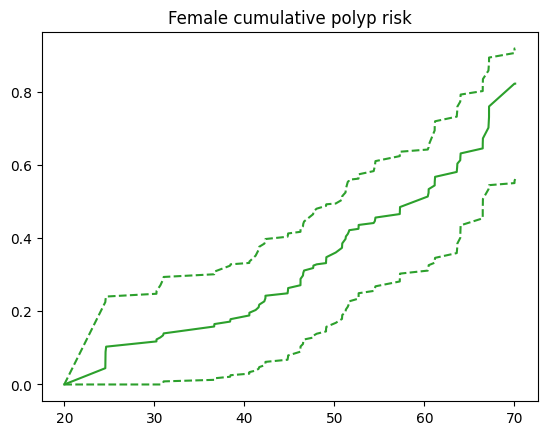

In [92]:
plt.plot(df_wide_m.age, df_wide_m.loc[:,'upper'], '--', color='C0')
plt.plot(df_wide_m.age, df_wide_m.loc[:,'value'], color='C0')
plt.plot(df_wide_m.age, df_wide_m.loc[:,'lower'], '--', color='C0')
plt.title("Male cumulative polyp risk")
plt.show()

plt.plot(df_wide_f.age, df_wide_f.loc[:,'upper'], '--', color='C2')
plt.plot(df_wide_f.age, df_wide_f.loc[:,'value'], color='C2')
plt.plot(df_wide_f.age, df_wide_f.loc[:,'lower'], '--', color='C2')
plt.title("Female cumulative polyp risk")
plt.show()

## Correct the digitization
We know the true value for this data as reported by Mecklin et al for **age 60**. 
* Male: 0.685 (0.505, 0.80)
* Female: 0.483 (0.291, 0.622)

Let's check how far off our digitation is:

In [93]:
print("Male \n", df_wide_m.query('58 < age < 69'))
print("\nFemale \n", df_wide_f.query('55 < age < 61'))

Male 
 item        age     lower     upper     value
74    58.010277  0.503740  0.839520  0.704079
75    68.608881  0.510897  0.858825  0.722508
76    68.653080  0.518053  0.868630  0.740937
77    68.674253  0.525209  0.878436  0.766646

Female 
 item        age     lower     upper     value
50    57.262311  0.281623  0.624358  0.465929
51    57.275637  0.294887  0.630356  0.475529
52    57.291729  0.303095  0.636353  0.485128
53    60.368926  0.311302  0.642350  0.513886
54    60.460879  0.319509  0.648348  0.523985
55    60.471906  0.326174  0.654345  0.534084


We are estimating a bit high on both counts. We'll assume that we've systematically overestimated for all ages, and will apply a scaler.

In [94]:
mu_f, lo_f, hi_f = 0.482, 0.291, 0.622
mu_m, lo_m, hi_m = 0.685, 0.505, 0.80

# Since we have a bit of a gap, lets linearly interpolate the val for 60
dummy = pd.DataFrame(data=[[60,np.nan,np.nan,np.nan]],columns=df_wide_m.columns, index=[0])
df_wide_m = pd.concat([df_wide_m, dummy],ignore_index=True).sort_values(by='age').reset_index(drop=True)
df_wide_f = pd.concat([df_wide_f, dummy],ignore_index=True).sort_values(by='age').reset_index(drop=True)
df_wide_m = df_wide_m.interpolate(method='linear')
df_wide_f = df_wide_f.interpolate(method='linear')

# Extract item
nearest_f = df_wide_f.query('age==60')
nearest_m = df_wide_m.query('age==60')

# Get scale values
scale_val_f = mu_f / nearest_f["value"].values[0]
scale_low_f = lo_f / nearest_f["lower"].values[0]
scale_upp_f = hi_f / nearest_f["upper"].values[0]

scale_val_m = mu_m / nearest_m["value"].values[0]
scale_low_m = lo_m / nearest_m["lower"].values[0]
scale_upp_m = hi_m / nearest_m["upper"].values[0]

# Apply scaling
df_wide_f["value_adj"] = df_wide_f["value"] * scale_val_f
df_wide_f["lower_adj"] = df_wide_f["lower"] * scale_low_f
df_wide_f["upper_adj"] = df_wide_f["upper"] * scale_upp_f

df_wide_m["value_adj"] = df_wide_m["value"] * scale_val_m
df_wide_m["lower_adj"] = df_wide_m["lower"] * scale_low_m
df_wide_m["upper_adj"] = df_wide_m["upper"] * scale_upp_m

In [95]:
print("Male \n", df_wide_m.query('58 < age < 69'))
print("\nFemale \n", df_wide_f.query('55 < age < 61'))

Male 
 item        age     lower     upper     value  value_adj  lower_adj  upper_adj
74    58.010277  0.503740  0.839520  0.704079   0.676151   0.501438   0.790907
75    60.000000  0.507319  0.849172  0.713294   0.685000   0.505000   0.800000
76    68.608881  0.510897  0.858825  0.722508   0.693849   0.508562   0.809093
77    68.653080  0.518053  0.868630  0.740937   0.711547   0.515685   0.818331
78    68.674253  0.525209  0.878436  0.766646   0.736236   0.522809   0.827569

Female 
 item        age     lower     upper     value  value_adj  lower_adj  upper_adj
50    57.262311  0.281623  0.624358  0.465929   0.449599   0.266773   0.607413
51    57.275637  0.294887  0.630356  0.475529   0.458862   0.279338   0.613248
52    57.291729  0.303095  0.636353  0.485128   0.468125   0.287113   0.619083
53    60.000000  0.307198  0.639352  0.499507   0.482000   0.291000   0.622000
54    60.368926  0.311302  0.642350  0.513886   0.495875   0.294887   0.624917
55    60.460879  0.319509  0.648348

In [96]:
def extract_csaps(data, val_type, smooth=0.1):
    d = data.loc[:,['age',val_type]]

    # Fit spline
    spline = csaps(d['age'], d[val_type], smooth=smooth)
    x = np.arange(20, 71, 1)
    y = spline(x).clip(0, 1)
    y = np.maximum.accumulate(y)  # Ensure monotonic
    return y

ages = np.arange(20, 71, 1)
df = pd.DataFrame({
    'sex': ['female'] * len(ages) + ['male'] * len(ages),
    'age': np.tile(ages, 2)  # repeat age array for each sex
})

# Extract values for each sex and concatenate
df_new_f = pd.DataFrame({
    'value': extract_csaps(df_wide_f, 'value', smooth=0.01),
    'lower': extract_csaps(df_wide_f, 'lower', smooth=0.01),
    'upper': extract_csaps(df_wide_f, 'upper', smooth=0.01)
}, index=range(len(ages)))

df_new_f['value'] = np.maximum(df_new_f['lower'], df_new_f['value'])
df_new_f['upper'] = np.maximum(df_new_f['value'], df_new_f['upper'])

df_new_m = pd.DataFrame({
    'value': extract_csaps(df_wide_m, 'value', smooth=0.01),
    'lower': extract_csaps(df_wide_m, 'lower', smooth=0.01),
    'upper': extract_csaps(df_wide_m, 'upper', smooth=0.01)
},index=range(len(ages)))
df_new_m['value'] = np.maximum(df_new_m['lower'], df_new_m['value'])
df_new_m['upper'] = np.maximum(df_new_m['value'], df_new_m['upper'])
# Combine extracted values back into df
df[['value', 'lower', 'upper']] = pd.concat([df_new_f, df_new_m], ignore_index=True)

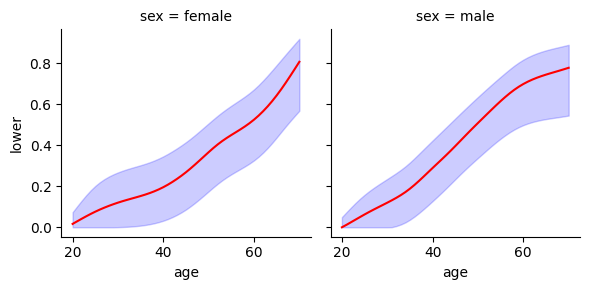

In [97]:
import seaborn as sns
g = sns.FacetGrid(df, col='sex', col_wrap=2)
g.map(plt.plot, 'age', 'value', color='red')
g.map(plt.fill_between, 'age', 'lower', 'upper', color='blue', alpha=0.2)
plt.show()

# g_clip = sns.FacetGrid(df, col='sex', col_wrap=2)
# g_clip.map(plt.plot, 'age', 'value', color='red')
# g_clip.map(plt.fill_between, 'age', 'lower', 'upper', color='blue', alpha=0.2)
# plt.show()

In [103]:
ages = np.arange(20, 71, 1)

# Step 1: Setup base DataFrame
df_clippy = pd.DataFrame({
    'sex': ['female'] * len(ages) + ['male'] * len(ages),
    'age': np.tile(ages, 2)
})

# Step 2: Clip source data
data_clip_f = df_wide_f.loc[df_wide_f['age'] <= 60].copy()
data_clip_m = df_wide_m.loc[df_wide_m['age'] <= 60].copy()

# Step 3: Extract data point at 60
val_60_f = [0.483,0.291,0.622]
val_60_m = [0.685,0.505,0.80]

dummy_f = pd.DataFrame({'age': 70,
                        'value': val_60_f[0]* 1.05, 
                        'lower': val_60_f[1]* 1.05, 
                        'upper': val_60_f[2]* 1.05
                        },index=[0])
dummy_m = pd.DataFrame({'age': 70,
                        'value': val_60_m[0]* 1.05, 
                        'lower': val_60_m[1]* 1.05, 
                        'upper': val_60_m[2]* 1.05
                        },index=[0])

data_clip_f = pd.concat([data_clip_f, dummy_f], ignore_index=True)
data_clip_m = pd.concat([data_clip_m, dummy_m], ignore_index=True)

data_clip_f = data_clip_f.sort_values(by=['age']).reset_index(drop=True)
data_clip_m = data_clip_m.sort_values(by=['age']).reset_index(drop=True)

# Step 5: Interpolate for each sex
df_clip_f = pd.DataFrame({
    'value': extract_csaps(data_clip_f, 'value', smooth=0.01),
    'lower': extract_csaps(data_clip_f, 'lower', smooth=0.01),
    'upper': extract_csaps(data_clip_f, 'upper', smooth=0.01)
}, index=range(len(ages)))

df_clip_f['value'] = np.maximum(df_clip_f['lower'], df_clip_f['value'])
df_clip_f['upper'] = np.maximum(df_clip_f['value'], df_clip_f['upper'])

df_clip_m = pd.DataFrame({
    'value': extract_csaps(data_clip_m, 'value', smooth=0.01),
    'lower': extract_csaps(data_clip_m, 'lower', smooth=0.01),
    'upper': extract_csaps(data_clip_m, 'upper', smooth=0.01)
}, index=range(len(ages)))

df_clip_m['value'] = np.maximum(df_clip_m['lower'], df_clip_m['value'])
df_clip_m['upper'] = np.maximum(df_clip_m['value'], df_clip_m['upper'])

# Step 6: Combine
df_combined_clip = pd.concat([df_clip_f, df_clip_m], ignore_index=True)
df_clippy[['value', 'lower', 'upper']] = df_combined_clip.reset_index(drop=True)


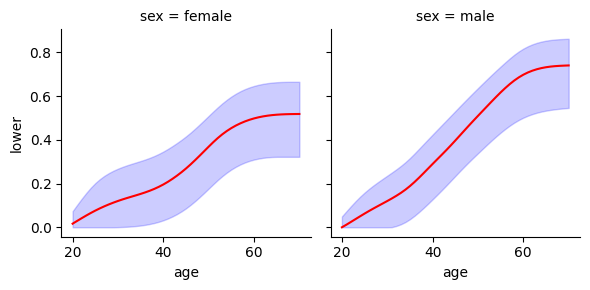

In [104]:
g_clip = sns.FacetGrid(df_clippy, col='sex', col_wrap=2)
g_clip.map(plt.plot, 'age', 'value', color='red')
g_clip.map(plt.fill_between, 'age', 'lower', 'upper', color='blue', alpha=0.2)
plt.show()

In [105]:
df_clippy['se'] = (df_clippy.upper - df_clippy.lower) / 2.0*1.96
df_clippy['var'] = df_clippy.se**2

In [106]:
df_clippy.loc[df_clippy['age']==60]

,sex,age,value,lower,upper,se,var
40,female,60,0.497713,0.309612,0.646243,0.329898,0.108833
91,male,60,0.697517,0.501128,0.816833,0.309391,0.095723


In [107]:
df_clippy.to_csv(os.path.join(DATA_DIR, "targets/adenoma_risk_cumulative_to_70.csv"),index=False)